In [2]:
#Para este proyecto, vamos a cojer datos de la app store y analizarlos, para ver cuales son las apps mas populares y en que categorias o generos pertenecen.

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, isnull, pow, sqrt, regexp_extract, regexp_replace, format_number, avg, round, lit
from pyspark.ml.feature import Imputer
from pyspark.sql.types import StructType

import os
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession.builder.appName("practica").getOrCreate()
spark.conf.set("spark.hadoop.mapreduce.fileoutputcommitter.marksuccessfuljobs", "false")

In [5]:
df = spark.read.csv("../raw/googleplaystore.csv", header=True, inferSchema=True)

In [6]:
#Para esta ocasion vamos a cojer un csv de apps y vamos a analyzarlo de diferentes maneras y aplicando graficas.

In [7]:
df.count()

10841

In [8]:
df.show()

+---+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------+------------------+------------+
|_c0|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|Last Updated|       Current Ver| Android Ver|
+---+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------+------------------+------------+
|  0|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|    10,000+|Free|    0|      Everyone|        Art & Design|    7-Jan-18|             1.0.0|4.0.3 and up|
|  1| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|   15-Jan-18|             2.0.0|4.0.3 and up|
|  2|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5,000,000+|Free|    0|      Everyone|        Art & Design|    1-Aug-18|             1.2.4|4.0.3 and up|
|  3

In [9]:
#tenemos la columna install en string, por eso nos da null
df.groupBy("Category").agg({'installs': 'mean'}).show()

+-------------------+-------------+
|           Category|avg(installs)|
+-------------------+-------------+
|             EVENTS|         NULL|
|             COMICS|         NULL|
|             SPORTS|         NULL|
|            WEATHER|         NULL|
|      VIDEO_PLAYERS|         NULL|
|  AUTO_AND_VEHICLES|         NULL|
|          PARENTING|         NULL|
|      ENTERTAINMENT|         NULL|
|    PERSONALIZATION|         NULL|
| HEALTH_AND_FITNESS|         NULL|
|   TRAVEL_AND_LOCAL|         NULL|
|BOOKS_AND_REFERENCE|         NULL|
|     FOOD_AND_DRINK|         NULL|
|        PHOTOGRAPHY|         NULL|
|           BUSINESS|         NULL|
|             FAMILY|          0.0|
|           SHOPPING|         NULL|
|     HOUSE_AND_HOME|         NULL|
|               GAME|         NULL|
|               Face|          4.2|
+-------------------+-------------+
only showing top 20 rows



In [10]:
df = df.withColumn("installs", regexp_replace("installs", "[+,]", ""))

In [11]:
df.select("Installs").show()

+--------+
|Installs|
+--------+
|   10000|
|  500000|
| 5000000|
|50000000|
|  100000|
|   50000|
|   50000|
| 1000000|
| 1000000|
|   10000|
| 1000000|
| 1000000|
|10000000|
|  100000|
|  100000|
|    5000|
|  500000|
|   10000|
| 5000000|
|10000000|
+--------+
only showing top 20 rows



In [12]:
df = df.withColumn("installs", df["installs"].cast("int"))

In [13]:
df.dtypes

[('_c0', 'int'),
 ('App', 'string'),
 ('Category', 'string'),
 ('Rating', 'string'),
 ('Reviews', 'string'),
 ('Size', 'string'),
 ('installs', 'int'),
 ('Type', 'string'),
 ('Price', 'string'),
 ('Content Rating', 'string'),
 ('Genres', 'string'),
 ('Last Updated', 'string'),
 ('Current Ver', 'string'),
 ('Android Ver', 'string')]

In [14]:
df.groupBy("category").agg(round(avg("installs"), 3).alias("mean_installs")).show()

+-------------------+--------------+
|           category| mean_installs|
+-------------------+--------------+
|             EVENTS|    249580.641|
|             COMICS|    934769.167|
|             SPORTS|   4560350.255|
|            WEATHER|   5196347.805|
|      VIDEO_PLAYERS|3.5554301257E7|
|  AUTO_AND_VEHICLES|    625061.306|
|          PARENTING|    525351.833|
|      ENTERTAINMENT|1.9256107383E7|
|    PERSONALIZATION|   5932384.648|
| HEALTH_AND_FITNESS|   4653154.447|
|   TRAVEL_AND_LOCAL|2.6623593589E7|
|BOOKS_AND_REFERENCE|   8318050.113|
|     FOOD_AND_DRINK|   2156683.079|
|        PHOTOGRAPHY|3.0114172104E7|
|           BUSINESS|   2178075.793|
|             FAMILY|   5201959.181|
|           SHOPPING|1.2491726096E7|
|     HOUSE_AND_HOME|   1917187.057|
|               GAME|3.0669601761E7|
|               Face|           4.0|
+-------------------+--------------+
only showing top 20 rows



In [15]:
#vamos con algo mas avanzado, vamos a cojer solo las 5 mejores.

In [16]:
medias = df.groupBy("category").agg(round(avg("installs"), 3).alias("mean_installs"))

In [17]:
medias_install = medias.orderBy(col("mean_installs").desc())

In [18]:
medias_install.limit(5).show()

+-------------+--------------+
|     category| mean_installs|
+-------------+--------------+
|COMMUNICATION|8.4359886953E7|
|       SOCIAL|4.7694467464E7|
|VIDEO_PLAYERS|3.5554301257E7|
| PRODUCTIVITY|3.3434177757E7|
|         GAME|3.0669601761E7|
+-------------+--------------+



In [19]:
#Productivity puede estar relacionado con el mismo trabajo o control sobre uno mismo, social pueden ser redes sociales.
#En muchas ocasiones las redes sociales estan relacionadas con el ocio.

In [20]:
medias.limit(10).show()

#Imagino whatsapp y otras como telegram son comunicacion, tiene sentido.
#vamos a seguir explorando la dataframe.

+------------------+--------------+
|          category| mean_installs|
+------------------+--------------+
|            EVENTS|    249580.641|
|            COMICS|    934769.167|
|            SPORTS|   4560350.255|
|           WEATHER|   5196347.805|
|     VIDEO_PLAYERS|3.5554301257E7|
| AUTO_AND_VEHICLES|    625061.306|
|         PARENTING|    525351.833|
|     ENTERTAINMENT|1.9256107383E7|
|   PERSONALIZATION|   5932384.648|
|HEALTH_AND_FITNESS|   4653154.447|
+------------------+--------------+



In [21]:
df.show()

+---+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+------------+------------------+------------+
|_c0|                 App|      Category|Rating|Reviews|Size|installs|Type|Price|Content Rating|              Genres|Last Updated|       Current Ver| Android Ver|
+---+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+------------+------------------+------------+
|  0|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|   10000|Free|    0|      Everyone|        Art & Design|    7-Jan-18|             1.0.0|4.0.3 and up|
|  1| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|  500000|Free|    0|      Everyone|Art & Design;Pret...|   15-Jan-18|             2.0.0|4.0.3 and up|
|  2|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5000000|Free|    0|      Everyone|        Art & Design|    1-Aug-18|             1.2.4|4.0.3 and up|
|  3|Sketch - Draw & P

In [22]:
df.dtypes

[('_c0', 'int'),
 ('App', 'string'),
 ('Category', 'string'),
 ('Rating', 'string'),
 ('Reviews', 'string'),
 ('Size', 'string'),
 ('installs', 'int'),
 ('Type', 'string'),
 ('Price', 'string'),
 ('Content Rating', 'string'),
 ('Genres', 'string'),
 ('Last Updated', 'string'),
 ('Current Ver', 'string'),
 ('Android Ver', 'string')]

In [23]:
#vamos a mirar los rating de cada categoria.

df = df.withColumn("Rating", df["Rating"].cast("float"))

In [24]:
df.dtypes

[('_c0', 'int'),
 ('App', 'string'),
 ('Category', 'string'),
 ('Rating', 'float'),
 ('Reviews', 'string'),
 ('Size', 'string'),
 ('installs', 'int'),
 ('Type', 'string'),
 ('Price', 'string'),
 ('Content Rating', 'string'),
 ('Genres', 'string'),
 ('Last Updated', 'string'),
 ('Current Ver', 'string'),
 ('Android Ver', 'string')]

In [25]:
df.groupBy("category").agg(round(avg("rating"), 3).alias("rating")).show()

+-------------------+------+
|           category|rating|
+-------------------+------+
|             EVENTS| 4.436|
|             COMICS| 4.155|
|             SPORTS| 4.224|
|            WEATHER| 4.244|
|      VIDEO_PLAYERS| 4.064|
|  AUTO_AND_VEHICLES|  4.19|
|          PARENTING|   4.3|
|      ENTERTAINMENT| 4.126|
|    PERSONALIZATION| 4.336|
| HEALTH_AND_FITNESS| 4.277|
|   TRAVEL_AND_LOCAL| 4.109|
|BOOKS_AND_REFERENCE| 4.346|
|     FOOD_AND_DRINK| 4.167|
|        PHOTOGRAPHY| 4.192|
|           BUSINESS| 4.121|
|             FAMILY| 4.192|
|           SHOPPING|  4.26|
|     HOUSE_AND_HOME| 4.197|
|               GAME| 4.286|
|               Face|  NULL|
+-------------------+------+
only showing top 20 rows



In [26]:
#Parece que face tiene algo raro, vamos a verlo por si acaso.

In [27]:
df_testeo = spark.read.csv("../raw/googleplaystore.csv", header=True, inferSchema=True)

In [28]:
df_testeo.filter(df_testeo["category"] == "Face").show()

+----+--------------------+--------+------+-------------+------------------+--------+----+-----+--------------+------+------------+-----------+----------------+
| _c0|                 App|Category|Rating|      Reviews|              Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|     Android Ver|
+----+--------------------+--------+------+-------------+------------------+--------+----+-----+--------------+------+------------+-----------+----------------+
|6105|"Women""s Health ...|    Face|  Body|weight lose)"|HEALTH_AND_FITNESS|     4.2|2509| 5.0M|    1,000,000+|  Free|           0| Mature 17+|Health & Fitness|
+----+--------------------+--------+------+-------------+------------------+--------+----+-----+--------------+------+------------+-----------+----------------+



In [29]:
#ya veo, al parecer solo hay una, y tiene 4.2 installs? es algo raro, ademas su Rating es "Body"
#parece que en rating pusieron Body y luego se fastidio la fila, es decir, no podemos usarla como tal.
#la vamos a quitar.

In [30]:
df = df.filter(df["category"] != "Face")

In [31]:
df.groupBy("category").agg(round(avg("rating"), 3).alias("rating")).show(100)

+-------------------+------+
|           category|rating|
+-------------------+------+
|             EVENTS| 4.436|
|             COMICS| 4.155|
|             SPORTS| 4.224|
|            WEATHER| 4.244|
|      VIDEO_PLAYERS| 4.064|
|  AUTO_AND_VEHICLES|  4.19|
|          PARENTING|   4.3|
|      ENTERTAINMENT| 4.126|
|    PERSONALIZATION| 4.336|
| HEALTH_AND_FITNESS| 4.277|
|   TRAVEL_AND_LOCAL| 4.109|
|BOOKS_AND_REFERENCE| 4.346|
|     FOOD_AND_DRINK| 4.167|
|        PHOTOGRAPHY| 4.192|
|           BUSINESS| 4.121|
|             FAMILY| 4.192|
|           SHOPPING|  4.26|
|     HOUSE_AND_HOME| 4.197|
|               GAME| 4.286|
|                1.9|  19.0|
|          EDUCATION| 4.389|
|       PRODUCTIVITY| 4.211|
|              TOOLS| 4.047|
|          LIFESTYLE| 4.095|
| NEWS_AND_MAGAZINES| 4.132|
|            MEDICAL| 4.189|
|      COMMUNICATION| 4.159|
|MAPS_AND_NAVIGATION| 4.049|
|             DATING| 3.971|
|       traffic jams|  NULL|
| LIBRARIES_AND_DEMO| 4.178|
|             

In [32]:
#tambien estan 1.9 y traffic jams.
#Vamos a mirarlas.

In [33]:
df_testeo.filter(df_testeo["category"] == "1.9").show()
#esta tambien la voy a quitar.

+-----+--------------------+--------+------+-------+------+--------+----+--------+--------------+---------+------------+-----------+-----------+
|  _c0|                 App|Category|Rating|Reviews|  Size|Installs|Type|   Price|Content Rating|   Genres|Last Updated|Current Ver|Android Ver|
+-----+--------------------+--------+------+-------+------+--------+----+--------+--------------+---------+------------+-----------+-----------+
|10472|Life Made WI-Fi T...|     1.9|    19|   3.0M|1,000+|    Free|   0|Everyone|          NULL|11-Feb-18|      1.0.19| 4.0 and up|       NULL|
+-----+--------------------+--------+------+-------+------+--------+----+--------+--------------+---------+------------+-----------+-----------+



In [34]:
df_testeo.filter(df_testeo["category"] == "traffic_jams").show()

#Nada? probemos de otra forma.

+---+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|_c0|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
+---+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



In [35]:
df.filter(col("category").contains("traffic")).show()

#ahi la tenemos, no parece ser relevante por lo que la voy a quitar.

+----+--------------------+-------------+------+--------+-------------------+--------+------+------------------+--------------+------+------------+-----------+-----------------+
| _c0|                 App|     Category|Rating| Reviews|               Size|installs|  Type|             Price|Content Rating|Genres|Last Updated|Current Ver|      Android Ver|
+----+--------------------+-------------+------+--------+-------------------+--------+------+------------------+--------------+------+------------+-----------+-----------------+
|3838|"Yanosik: ""antyr...| traffic jams|  NULL| camera"|MAPS_AND_NAVIGATION|       4|102248|Varies with device|    5,000,000+|  Free|           0|   Everyone|Maps & Navigation|
+----+--------------------+-------------+------+--------+-------------------+--------+------+------------------+--------------+------+------------+-----------+-----------------+



In [36]:
df = df.filter(df["category"] != "1.9")
df = df.filter(~col("category").contains("traffic"))

In [37]:
#probemos de nuevo.

df.groupBy("category").agg(round(avg("rating"), 3).alias("rating")).show(100)

+-------------------+------+
|           category|rating|
+-------------------+------+
|             EVENTS| 4.436|
|             COMICS| 4.155|
|             SPORTS| 4.224|
|            WEATHER| 4.244|
|      VIDEO_PLAYERS| 4.064|
|  AUTO_AND_VEHICLES|  4.19|
|          PARENTING|   4.3|
|      ENTERTAINMENT| 4.126|
|    PERSONALIZATION| 4.336|
| HEALTH_AND_FITNESS| 4.277|
|   TRAVEL_AND_LOCAL| 4.109|
|BOOKS_AND_REFERENCE| 4.346|
|     FOOD_AND_DRINK| 4.167|
|        PHOTOGRAPHY| 4.192|
|           BUSINESS| 4.121|
|             FAMILY| 4.192|
|           SHOPPING|  4.26|
|     HOUSE_AND_HOME| 4.197|
|               GAME| 4.286|
|          EDUCATION| 4.389|
|       PRODUCTIVITY| 4.211|
|              TOOLS| 4.047|
|          LIFESTYLE| 4.095|
| NEWS_AND_MAGAZINES| 4.132|
|            MEDICAL| 4.189|
|      COMMUNICATION| 4.159|
|MAPS_AND_NAVIGATION| 4.049|
|             DATING| 3.971|
| LIBRARIES_AND_DEMO| 4.178|
|             BEAUTY| 4.279|
|             SOCIAL| 4.256|
|            F

In [38]:
#Vamos a ver ambas cosas ahora, tanto la media de rating como de descargas.
df.groupBy("Category").agg(round(avg("installs"),3).alias("avg_installs"), round(avg("Rating"),3).alias("avg_rating")).show()

+-------------------+--------------+----------+
|           Category|  avg_installs|avg_rating|
+-------------------+--------------+----------+
|             EVENTS|    249580.641|     4.436|
|             COMICS|    934769.167|     4.155|
|             SPORTS|   4560350.255|     4.224|
|            WEATHER|   5196347.805|     4.244|
|      VIDEO_PLAYERS|3.5554301257E7|     4.064|
|  AUTO_AND_VEHICLES|    625061.306|      4.19|
|          PARENTING|    525351.833|       4.3|
|      ENTERTAINMENT|1.9256107383E7|     4.126|
|    PERSONALIZATION|   5932384.648|     4.336|
| HEALTH_AND_FITNESS|   4653154.447|     4.277|
|   TRAVEL_AND_LOCAL|2.6623593589E7|     4.109|
|BOOKS_AND_REFERENCE|   8318050.113|     4.346|
|     FOOD_AND_DRINK|   2156683.079|     4.167|
|        PHOTOGRAPHY|3.0114172104E7|     4.192|
|           BUSINESS|   2178075.793|     4.121|
|             FAMILY|   5201959.181|     4.192|
|           SHOPPING|1.2491726096E7|      4.26|
|     HOUSE_AND_HOME|   1917187.057|    

In [39]:
#vamos a representarlo con mathplotlib, por lo que veo no se puede hacer directamente desde spark, usaremos .toPandas.

ambas_medias = df.groupBy("Category").agg(round(avg("installs"),3).alias("avg_installs"), round(avg("Rating"),3).alias("avg_rating"))

In [40]:
ambas_medias = ambas_medias.toPandas()

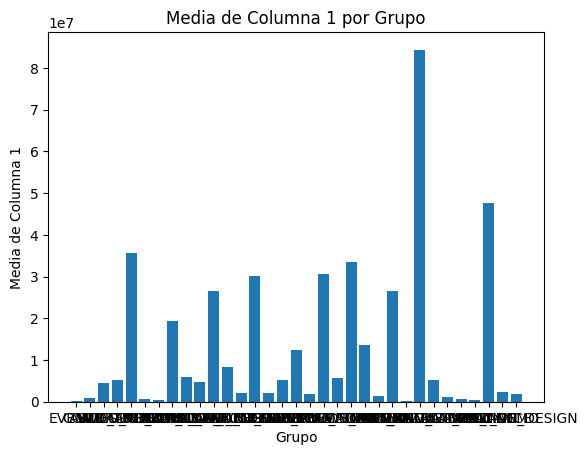

In [41]:
#por el momento veo que no se puede hacer desde spark
plt.bar(ambas_medias["Category"],ambas_medias["avg_installs"])
plt.title('Media de Columna 1 por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Media de Columna 1')
plt.show()

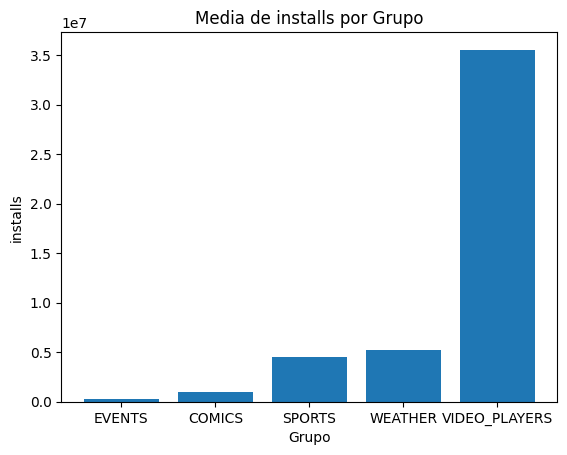

In [42]:
#mejor cogere solo los 5 primeros.

plt.bar(ambas_medias["Category"].head(5),ambas_medias["avg_installs"].head(5))
plt.title('Media de installs por Grupo')
plt.xlabel('Grupo')
plt.ylabel('installs')
plt.show()

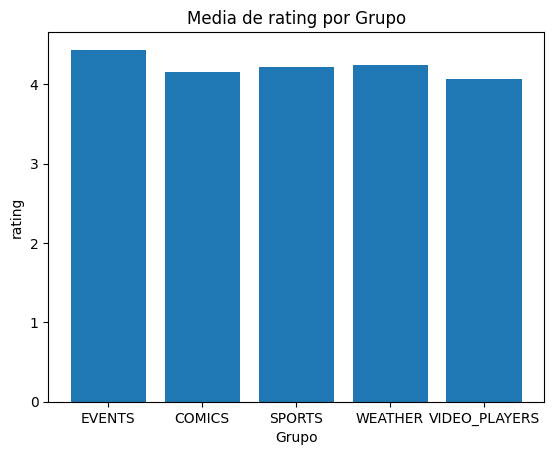

In [43]:
#mejor cogere solo los 5 primeros.

plt.bar(ambas_medias["Category"].head(5),ambas_medias["avg_rating"].head(5))
plt.title('Media de rating por Grupo')
plt.xlabel('Grupo')
plt.ylabel('rating')
plt.show()

In [44]:
df.show()

+---+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+------------+------------------+------------+
|_c0|                 App|      Category|Rating|Reviews|Size|installs|Type|Price|Content Rating|              Genres|Last Updated|       Current Ver| Android Ver|
+---+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+------------+------------------+------------+
|  0|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|   10000|Free|    0|      Everyone|        Art & Design|    7-Jan-18|             1.0.0|4.0.3 and up|
|  1| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|  500000|Free|    0|      Everyone|Art & Design;Pret...|   15-Jan-18|             2.0.0|4.0.3 and up|
|  2|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5000000|Free|    0|      Everyone|        Art & Design|    1-Aug-18|             1.2.4|4.0.3 and up|
|  3|Sketch - Draw & P

In [45]:
"""unique_categories_df = df.groupBy("category").count()

# Para cada categoría, obtener los distintos tipos de "content rating"
category_content_rating_df = df.groupBy("category", "content rating").count()

# Calcular las medias de "Installs" y "Rating" para cada combinación de "category" y "content rating"
ratings_installs_avg_df = df.groupBy("category", "content rating").agg(avg("Installs").alias("avg_installs"), avg("Rating").alias("avg_rating"))

# Mostrar los resultados
unique_categories_df.show()
category_content_rating_df.show()
ratings_installs_avg_df.show()""";

In [46]:
#vamos a hacer algo mas avanzado, por el momento, cogere todos los tipos de category y los guardare en una lista.

In [47]:
unicos = df.select("Category").distinct().collect()

In [48]:
unicos[0][0]

'EVENTS'

In [49]:
for i,j in enumerate(unicos):
    unicos[i] = unicos[i][0]

In [50]:
unicos[0]

'EVENTS'

In [51]:
#ahora, vamos a coger cada elemento de la lista, y lo usaremos para crear una nueva DF.


In [52]:
#vemos que ya funciona, aunque le falta un poco.
for i in unicos:
    filas = df.filter(df["category"] == i)
    grouped_df = filas.groupBy("content rating").count()
    media_installs_rating = filas.groupBy("content rating").agg(round(avg("installs"), 3).alias("avg_installs"), round(avg("Rating"), 3).alias("avg_rating"))
    grouped_df = grouped_df.join(media_installs_rating, on="content rating")
    grouped_df.show()


+--------------+-----+------------+----------+
|content rating|count|avg_installs|avg_rating|
+--------------+-----+------------+----------+
|          Teen|    8|   138388.75|     4.543|
|  Everyone 10+|    3|     33700.0|       4.5|
|      Everyone|   53|  278583.981|     4.411|
+--------------+-----+------------+----------+

+---------------+-----+------------+----------+
| content rating|count|avg_installs|avg_rating|
+---------------+-----+------------+----------+
|           Teen|   22| 1808636.364|     4.032|
|     Mature 17+|    7|    330000.0|     3.771|
|   Everyone 10+|    3|  170016.667|      4.45|
|       Everyone|   26|    479850.0|     4.344|
|Adults only 18+|    2|    500000.0|       4.2|
+---------------+-----+------------+----------+

+---------------+-----+------------+----------+
| content rating|count|avg_installs|avg_rating|
+---------------+-----+------------+----------+
|           Teen|   16|   8910100.0|      4.14|
|     Mature 17+|    7| 3857142.857|     4.28

In [53]:
#primero creamos lo necesario para crear una dataframe vacia.
for i in unicos:
    filas = df.filter(df["category"] == i)

    grouped_df = filas.groupBy("content rating").count()
    media_installs_rating = filas.groupBy("content rating").agg(round(avg("installs"), 3).alias("avg_installs"), round(avg("Rating"), 3).alias("avg_rating"))
    grouped_df = grouped_df.join(media_installs_rating, on="content rating")
    grouped_df = grouped_df.withColumn("Category", lit(i))
    grouped_df = grouped_df.selectExpr("Category", "*")
    #aqui tenemos un problema, la columna "Category" aparece 2 veces, y yo la quiero solo a la izq.
    #Cojo todas excepto la ultima y ya lo tenemos.
    df_final = grouped_df.select(grouped_df.columns[:-1])
    df_final.show()


+--------+--------------+-----+------------+----------+
|Category|content rating|count|avg_installs|avg_rating|
+--------+--------------+-----+------------+----------+
|  EVENTS|          Teen|    8|   138388.75|     4.543|
|  EVENTS|  Everyone 10+|    3|     33700.0|       4.5|
|  EVENTS|      Everyone|   53|  278583.981|     4.411|
+--------+--------------+-----+------------+----------+

+--------+---------------+-----+------------+----------+
|Category| content rating|count|avg_installs|avg_rating|
+--------+---------------+-----+------------+----------+
|  COMICS|           Teen|   22| 1808636.364|     4.032|
|  COMICS|     Mature 17+|    7|    330000.0|     3.771|
|  COMICS|   Everyone 10+|    3|  170016.667|      4.45|
|  COMICS|       Everyone|   26|    479850.0|     4.344|
|  COMICS|Adults only 18+|    2|    500000.0|       4.2|
+--------+---------------+-----+------------+----------+

+--------+---------------+-----+------------+----------+
|Category| content rating|count|avg_

In [55]:
#¿Que podemos hacer con todas esas df?
#Pues las vamos a guardar todas y cada una en su carpeta como dios manda.

#primero creamos lo necesario para crear una dataframe vacia.
for i in unicos:
    filas = df.filter(df["category"] == i)

    grouped_df = filas.groupBy("content rating").count()
    media_installs_rating = filas.groupBy("content rating").agg(round(avg("installs"), 3).alias("avg_installs"), round(avg("Rating"), 3).alias("avg_rating"))
    grouped_df = grouped_df.join(media_installs_rating, on="content rating")
    grouped_df = grouped_df.withColumn("Category", lit(i))
    grouped_df = grouped_df.selectExpr("Category", "*")
    #aqui tenemos un problema, la columna "Category" aparece 2 veces, y yo la quiero solo a la izq.
    #Cojo todas excepto la ultima y ya lo tenemos.
    df_final = grouped_df.select(grouped_df.columns[:-1])
    df_final.show()

    df_final.write.option("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false").csv(f"../data/processed/df_filtradas/{i}", header=True, mode="overwrite")

    #Con esto miraremos la lista de archivos, el CSV estara el ultimo, le cambiamos el nombre a uno mas apropiado.
    archivos = os.listdir(f"../data/processed/df_filtradas/{i}")

    antes = os.path.join(f"../data/processed/df_filtradas/{i}", archivos[-1])
    despues = os.path.join(f"../data/processed/df_filtradas/{i}", f"{i}.csv")


    os.rename(antes, despues)

+--------+--------------+-----+------------+----------+
|Category|content rating|count|avg_installs|avg_rating|
+--------+--------------+-----+------------+----------+
|  EVENTS|          Teen|    8|   138388.75|     4.543|
|  EVENTS|  Everyone 10+|    3|     33700.0|       4.5|
|  EVENTS|      Everyone|   53|  278583.981|     4.411|
+--------+--------------+-----+------------+----------+

+--------+---------------+-----+------------+----------+
|Category| content rating|count|avg_installs|avg_rating|
+--------+---------------+-----+------------+----------+
|  COMICS|           Teen|   22| 1808636.364|     4.032|
|  COMICS|     Mature 17+|    7|    330000.0|     3.771|
|  COMICS|   Everyone 10+|    3|  170016.667|      4.45|
|  COMICS|       Everyone|   26|    479850.0|     4.344|
|  COMICS|Adults only 18+|    2|    500000.0|       4.2|
+--------+---------------+-----+------------+----------+

+--------+---------------+-----+------------+----------+
|Category| content rating|count|avg_